# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

### Download Cifar10 dataset

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_PATH = '/your_path'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

# Augmented transforms for the training dataset
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(
        degrees=(-5, 5), translate=(0, 0.1), scale=(1.0, 1.25), shear=(-10, 10)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Applying augmented transforms only to the training dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                 transform=train_transforms)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Transforms for the validation and test datasets
val_test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Applying val_test_transforms to both validation and test datasets
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                               transform=val_test_transforms)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                                transform=val_test_transforms)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                         sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /your_path
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.1), scale=(1.0, 1.25), shear=[-10.0, 10.0])
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
train_loader.batch_size

64

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)

### Using  GPUs

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: dog


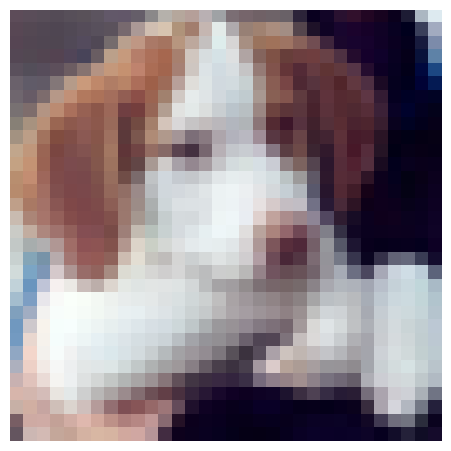

In [8]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


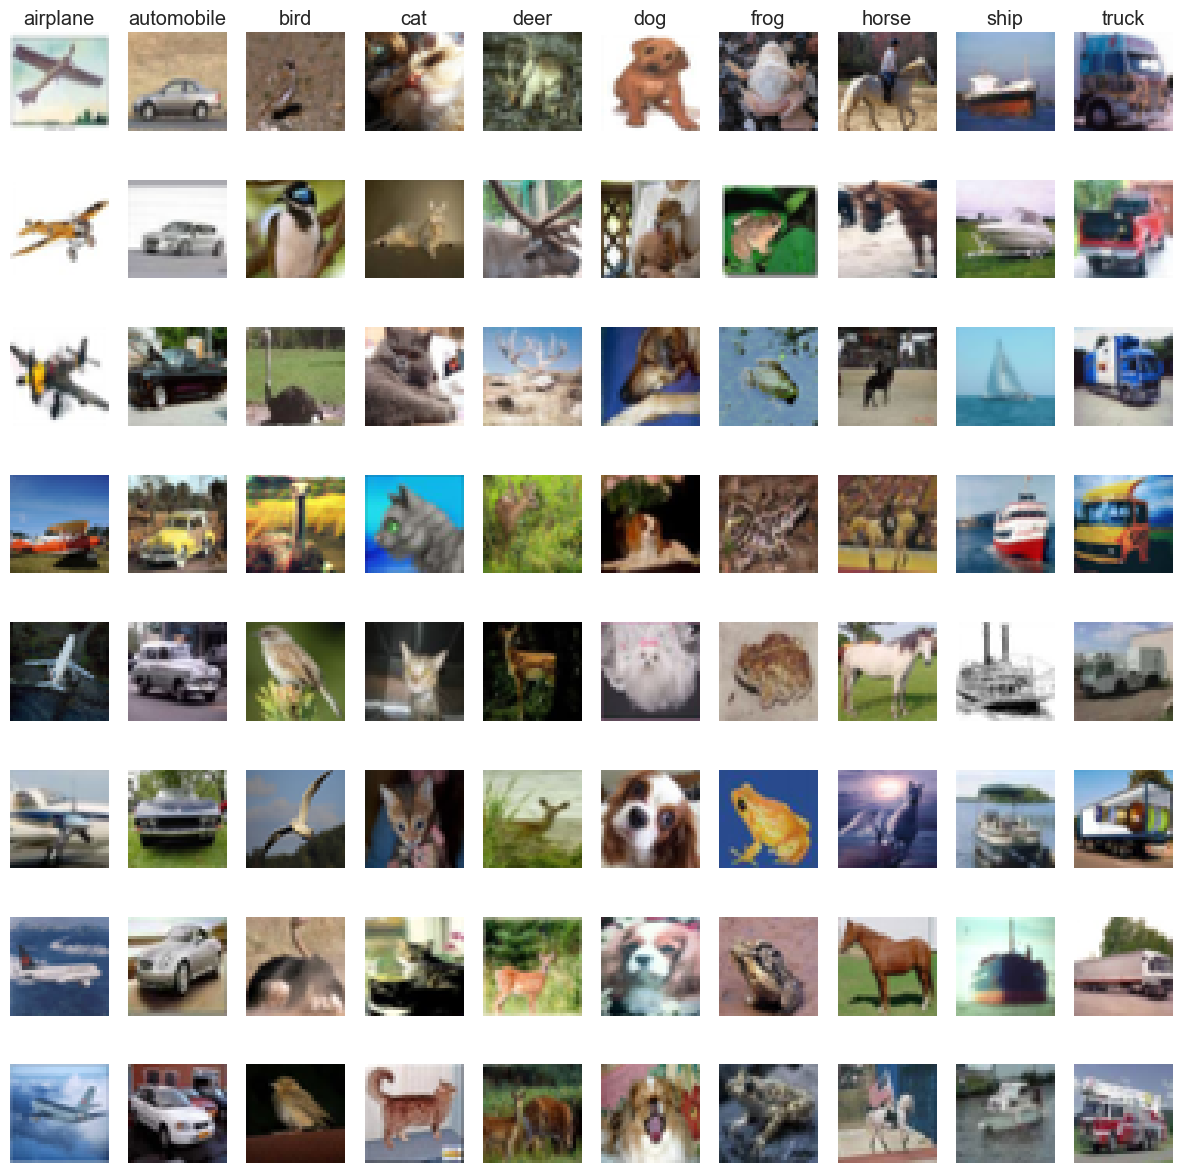

In [9]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [10]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) 
            num_correct += (pred == yi.squeeze()).sum().item() 
            num_total += pred.size(0)
        acc = float(num_correct) / num_total
        avg_cost = cost / len(loader)
        return avg_cost, acc

### Loop de entrenamiento

In [11]:

def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        model.train()
        for xi, yi in train_loader:
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # function cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum().item()
            train_total += scores.size(0)  
            
            train_cost_acum += cost.item()
        
        val_cost, val_acc = accuracy(model, val_loader)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum / len(train_loader)
        if epoch % 20 == 0:            
            print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                  f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                  f' lr: {optimiser.param_groups[0]["lr"]:.6f}')

### Linear model

In [16]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
# Define the Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Create an instance of the model
input_dim = 3 * 32 * 32  # CIFAR-10 input dimensions
output_dim = 10  # CIFAR-10 number of classes
model1 = LinearModel(input_dim, output_dim).to(device)

# Define the optimizer
lr = 1e-3  # Learning rate
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

# Define the number of epochs
epochs = 100



In [17]:
train(model1, optimiser, epochs)

Epoch:0, train cost: 1.922776, val cost: 1.833136, train acc: 0.3318, val acc: 0.376400, lr: 0.001000
Epoch:20, train cost: 1.673073, val cost: 1.694907, train acc: 0.4340, val acc: 0.420200, lr: 0.001000
Epoch:40, train cost: 1.642092, val cost: 1.701160, train acc: 0.4436, val acc: 0.417800, lr: 0.001000
Epoch:60, train cost: 1.625850, val cost: 1.698782, train acc: 0.4504, val acc: 0.418400, lr: 0.001000
Epoch:80, train cost: 1.615020, val cost: 1.701036, train acc: 0.4548, val acc: 0.417600, lr: 0.001000


### Sequential CNN

In [12]:
class CNNModel(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.4) -> None:
        super(CNNModel, self).__init__()

        # Feature extraction layers
        # The sequential layers consist of convolutional, batch normalization, 
        # ReLU activation, and max pooling layers.
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Second convolutional block
            nn.Conv2d(16, 32, kernel_size=3, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Third convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Fourth convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Fifth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Sixth convolutional block
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Calculate the size of the features after the convolutions and pooling
        # Starting size: 32x32
        # After three MaxPool2d(2, 2): 32 -> 16 -> 8 -> 4 (spatial dimensions)
        # Number of channels: 256 (from the last Conv2d layer)
        # Therefore, 4*4*256 = 4096
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 500),  
            nn.Dropout(dropout),
            nn.BatchNorm1d(500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create an instance of the adapted model
cnn_model = CNNModel(dropout=0.75).to(device)


In [38]:
# Defining the criterion and optimizer for the adapted_model

# train(cnn_model, optimiser, epochs)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), weight_decay=1e-3)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
epochs = 100
steps = 0
print_every = 20
running_loss = 0
patience = 10  # Stop training after this many epochs without improvement
epochs_without_improvement = 0
best_validation_loss = float('inf')  # Initialize with a high value

# Track losses for plotting
train_losses, validation_losses = [], []

# Move the model to the appropriate device (CPU or GPU)
cnn_model.to(device)

# Learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Training and validation loop
for epoch in range(epochs):
    # Training loop
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Validation loop
        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            cnn_model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = cnn_model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    validation_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Back to training mode
            cnn_model.train()
            
            train_losses.append(running_loss/len(train_loader))
            validation_losses.append(validation_loss/len(val_loader))
            
            # Print statistics
            print(f"Epoch: {epoch+1}/{epochs}.. "
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. "
                  f"Validation Loss: {validation_loss/len(val_loader):.3f}.. "
                  f"Validation Accuracy: {accuracy/len(val_loader):.3f}")
            
            running_loss = 0
    
    # Update learning rate using the scheduler after each epoch
    # Update learning rate if validation loss plateaus
    scheduler.step(validation_loss)

    # Check for validation loss improvement after each epoch
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Check patience after each epoch
    if epochs_without_improvement >= patience:
        print("Stopping training due to lack of validation loss improvement.")
        break



Epoch: 1/100.. Training Loss: 0.056.. Validation Loss: 2.111.. Validation Accuracy: 0.240
Epoch: 1/100.. Training Loss: 0.050.. Validation Loss: 3.276.. Validation Accuracy: 0.139
Epoch: 1/100.. Training Loss: 0.048.. Validation Loss: 1.961.. Validation Accuracy: 0.294
Epoch: 1/100.. Training Loss: 0.045.. Validation Loss: 1.826.. Validation Accuracy: 0.312
Epoch: 1/100.. Training Loss: 0.044.. Validation Loss: 3.197.. Validation Accuracy: 0.199
Epoch: 1/100.. Training Loss: 0.044.. Validation Loss: 2.394.. Validation Accuracy: 0.267
Epoch: 1/100.. Training Loss: 0.042.. Validation Loss: 1.981.. Validation Accuracy: 0.322
Epoch: 1/100.. Training Loss: 0.041.. Validation Loss: 2.341.. Validation Accuracy: 0.267
Epoch: 1/100.. Training Loss: 0.039.. Validation Loss: 2.360.. Validation Accuracy: 0.322
Epoch: 1/100.. Training Loss: 0.039.. Validation Loss: 2.703.. Validation Accuracy: 0.271
Epoch: 1/100.. Training Loss: 0.040.. Validation Loss: 1.988.. Validation Accuracy: 0.351
Epoch: 1/1

In [15]:
def calculate_accuracy(model, data_loader):
    correct = 0
    total = 0

    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            # If you're using a GPU
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate and print test accuracy
cnn_model = cnn_model.to(device)
test_accuracy = calculate_accuracy(cnn_model, test_loader)
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 83.84%
